In [ ]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import os
from dotenv import load_dotenv

load_dotenv()
PROJECT_ID = os.getenv('GCP_PROJECT_ID')
DATASET_ID = os.getenv('BIGQUERY_DATASET_ID')
client = bigquery.Client()

In [ ]:
query = """
SELECT
    name,
    team,
    season,
    avg AS normal_avg,
    batting_average_at_risp AS risp_avg,
    slg,
    obp,
    iso,
    babip,
    woba,
    contactpct,
    zonepct,
    barrelpct,
    hardhitpct,
    (so * 100.0 / pa) AS k_rate,
    (bb * 100.0 / pa) AS bb_rate,
    hr,
    rbi,
    pa,
    pa_at_risp,
    hits_at_risp,
    at_bats_at_risp
FROM `{PROJECT_ID}.{DATASET_ID}.fact_batting_stats_with_risp`
WHERE season = 2025
  AND pa >= 300  -- レギュラー選手のみ
  AND pa_at_risp >= 50  -- 得点圏打席が十分にある選手
ORDER BY name
"""

df = client.query(query).to_dataframe()
print(f"Number of eligible players: {df.shape[0]}")
df.head(10)

Number of eligible players: 243


c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,name,team,season,normal_avg,risp_avg,slg,obp,iso,babip,woba,...,barrelpct,hardhitpct,k_rate,bb_rate,hr,rbi,pa,pa_at_risp,hits_at_risp,at_bats_at_risp
0,Aaron Judge,NYY,2025,0.331,0.337,0.688,0.457,0.357,0.376,0.463,...,0.247,0.582,23.564065,18.262150,53,114,679,111,32,95
1,Adam Frazier,TRADED,2025,0.267,0.314,0.365,0.319,0.098,0.313,0.300,...,0.020,0.206,17.647059,5.664488,7,44,459,85,22,70
2,Adley Rutschman,BAL,2025,0.220,0.138,0.366,0.307,0.146,0.240,0.298,...,0.075,0.386,15.616438,10.958904,9,29,365,69,8,58
3,Adolis Garcia,TEX,2025,0.227,0.244,0.394,0.271,0.168,0.267,0.286,...,0.116,0.467,24.680073,5.118830,19,75,547,148,33,135
4,Alec Bohm,PHI,2025,0.287,0.306,0.409,0.331,0.123,0.324,0.322,...,0.062,0.464,16.269841,5.753968,11,59,504,122,33,108
5,Alec Burleson,STL,2025,0.290,0.262,0.459,0.343,0.169,0.312,0.346,...,0.094,0.428,14.468864,7.142857,18,69,546,119,27,103
6,Alejandro Kirk,TOR,2025,0.282,0.324,0.421,0.348,0.140,0.292,0.334,...,0.101,0.508,11.660079,9.486166,15,76,506,125,35,108
7,Alek Thomas,ARI,2025,0.249,0.242,0.370,0.289,0.120,0.324,0.287,...,0.078,0.393,26.012793,4.477612,9,38,469,108,24,99
8,Alex Bregman,BOS,2025,0.273,0.236,0.462,0.360,0.189,0.288,0.356,...,0.066,0.444,14.141414,10.303030,18,62,495,109,21,89
9,Alex Call,TRADED,2025,0.267,0.295,0.385,0.361,0.119,0.313,0.331,...,0.044,0.289,17.080745,11.180124,5,31,322,80,18,61


In [15]:
# Feature engineering
league_avg_risp = df['risp_avg'].mean()
league_avg_normal = df['normal_avg'].mean()

print(f"League Average (Normal): {league_avg_normal:.3f}")
print(f"League Average (RISP): {league_avg_risp:.3f}")

League Average (Normal): 0.252
League Average (RISP): 0.262


In [16]:
df['risp_vs_league'] = df['risp_avg'] - league_avg_risp
df['normal_vs_league'] = df['normal_avg'] - league_avg_normal

# クラッチ改善度 = RISP時のリーグ比較 - 通常時のリーグ比較
# これにより、「通常時の実力を考慮した上で、RISP時に期待以上のパフォーマンスを出しているか」を評価
df['clutch_improvement'] = df['risp_vs_league'] - df['normal_vs_league']

# クラッチフラッグ: clutch_improvementが正の値（=RISP時に期待以上のパフォーマンス）
df['clutch_flag'] = (df['clutch_improvement'] > 0).astype(int)

print("\nClutch Flag Distribution:")
print(df['clutch_flag'].value_counts())
print(f"\nClutch Improvement Stats:")
print(df['clutch_improvement'].describe())


Clutch Flag Distribution:
clutch_flag
1    124
0    119
Name: count, dtype: int64

Clutch Improvement Stats:
count    2.430000e+02
mean    -1.713307e-17
std      4.053454e-02
min     -1.233909e-01
25%     -2.989095e-02
50%      6.090535e-04
75%      3.060905e-02
max      1.026091e-01
Name: clutch_improvement, dtype: float64


In [17]:
# other features
df['risp_diff'] = df['risp_avg'] - df['normal_avg']
df['risp_pa_ratio'] = df['pa_at_risp'] / df['pa']

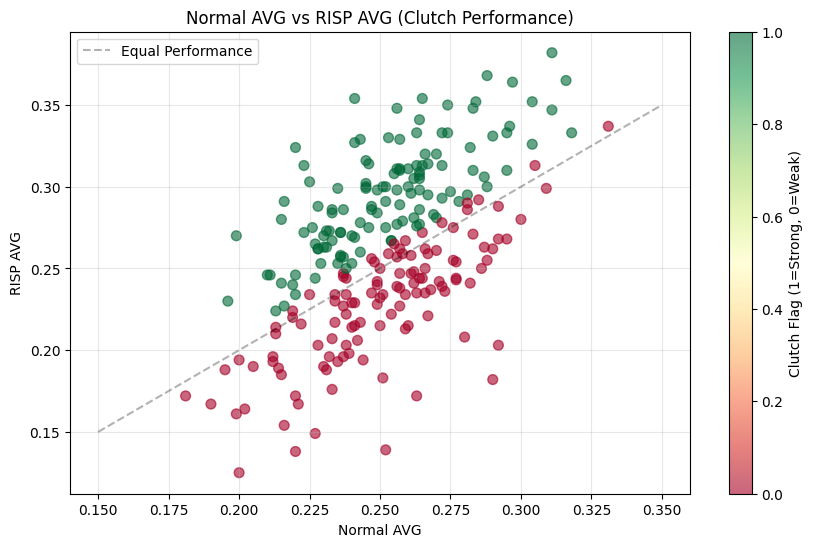

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df['normal_avg'], df['risp_avg'], alpha=0.6, c=df['clutch_flag'], cmap='RdYlGn', s=50)
plt.xlabel('Normal AVG')
plt.ylabel('RISP AVG')
plt.title('Normal AVG vs RISP AVG (Clutch Performance)')
plt.colorbar(label='Clutch Flag (1=Strong, 0=Weak)')
plt.plot([0.15, 0.35], [0.15, 0.35], 'k--', alpha=0.3, label='Equal Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Logistics Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Prepare the data
features = ['normal_avg', 'slg', 'obp', 'iso', 'babip', 'woba', 'contactpct', 'zonepct', 
            'barrelpct', 'hardhitpct', 'k_rate', 'bb_rate', 'risp_pa_ratio']
X = df[features]
y = df['clutch_flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41        24
           1       0.42      0.40      0.41        25

    accuracy                           0.41        49
   macro avg       0.41      0.41      0.41        49
weighted avg       0.41      0.41      0.41        49


ROC AUC Score: 0.425

Confusion Matrix:
[[10 14]
 [15 10]]

Feature Importance:
          feature  coefficient
10         k_rate     0.483244
2             obp     0.390773
5            woba     0.361900
6      contactpct     0.280374
7         zonepct     0.260140
12  risp_pa_ratio     0.184561
3             iso     0.018883
4           babip    -0.021784
1             slg    -0.036803
0      normal_avg    -0.096643
9      hardhitpct    -0.136756
8       barrelpct    -0.219139
11        bb_rate    -0.571987


In [8]:
print("\nTop 10 Clutch Performers:")
print(df.nlargest(10, 'clutch_improvement')[['name', 'team', 'normal_avg', 'risp_avg', 'clutch_improvement', 'clutch_flag']])

print("\nBottom 10 Clutch Performers:")
print(df.nsmallest(10, 'clutch_improvement')[['name', 'team', 'normal_avg', 'risp_avg', 'clutch_improvement', 'clutch_flag']])


Top 10 Clutch Performers:
                name team  normal_avg  risp_avg  clutch_improvement  \
125  Kyle Higashioka  TEX       0.241     0.354            0.102609   
61     Gabriel Arias  CLE       0.220     0.324            0.093609   
67    Gleyber Torres  DET       0.256     0.348            0.081609   
224    Tyrone Taylor  NYM       0.223     0.313            0.079609   
102  Jordan Westburg  BAL       0.265     0.354            0.078609   
152        Max Muncy  LAD       0.243     0.329            0.075609   
234    Wilmer Flores  SFG       0.241     0.327            0.075609   
29      Brice Turang  MIL       0.288     0.368            0.069609   
214      Tommy Edman  LAD       0.225     0.303            0.067609   
33      Byron Buxton  MIN       0.264     0.341            0.066609   

     clutch_flag  
125            1  
61             1  
67             1  
224            1  
102            1  
152            1  
234            1  
29             1  
214            1  
3